<a href="https://colab.research.google.com/github/Anitasulukhia/Multi-Task-Learning-with-a-Two-Headed-MLP/blob/main/DeepLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install ucimlrepo

In [2]:
from ucimlrepo import fetch_ucirepo
import pandas as pd
from sklearn.preprocessing import StandardScaler


# Loading data and combining into one dataframe, by default target values were
# different then required, so i joined every column into one dataframe and will later
# divide into features and targets

student_performance = fetch_ucirepo(id=320) # this returns object containing metadata, variables, features and targets
data = pd.concat([student_performance.data.features, student_performance.data.targets], axis=1)

# observation for which columns are already numeric and which ones
# should i convert

# for col in data.columns:
#   print(col)
#   print(data[col].unique())

data.isnull().sum() # checked if we had any nulls, turns out none


# for binary (yes, no) columns, i simply assign 1 and 0.

binary_map = {'yes': 1, 'no': 0}
data['schoolsup'] = data['schoolsup'].map(binary_map)
data['famsup'] = data['famsup'].map(binary_map)
data['paid'] = data['paid'].map(binary_map)
data['activities'] = data['activities'].map(binary_map)
data['nursery'] = data['nursery'].map(binary_map)
data['higher'] = data['higher'].map(binary_map)
data['internet'] = data['internet'].map(binary_map)
data['romantic'] = data['romantic'].map(binary_map)

# for categoriezed columns were we only have 2 options, also assign 1 and 0

data['sex'] = data['sex'].map({'F': 0, 'M': 1})
data['address'] = data['address'].map({'U': 1, 'R': 0})
data['famsize'] = data['famsize'].map({'GT3': 1, 'LE3': 0})
data['Pstatus'] = data['Pstatus'].map({'T': 1, 'A': 0})

# for more complex column i use onehotencoding

data = pd.get_dummies(
    data,
    columns=['school', 'Mjob', 'Fjob', 'reason', 'guardian'],
    drop_first=True
)

dummy_cols = data.select_dtypes(include=bool).columns
data[dummy_cols] = data[dummy_cols].astype(int) # turn them to ints


# now we standarlize numerical columns, centered at 0 and scaled. i actually
# implemented it but then noticed that it caused leakege. so i moved
# scalling after splitting into training/evaluation/test data






In [10]:
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from sklearn.preprocessing import StandardScaler



# split data into target/feature, train/evaluate/test sets

X = data.drop(["G3", "romantic"], axis=1)
# Regression target
y_grade = data["G3"]
# Classification target
y_romantic = data["romantic"]

# we now split data into - train and temporary (temp) with according romantic and grade tagrets
X_train, X_temp, y_grade_train, y_grade_temp, y_romantic_train, y_romantic_temp = train_test_split(
    X, y_grade, y_romantic, test_size=0.3, random_state=42 ,  stratify=y_romantic #results are reproducible and y_romantic yes/no answers are evenly distributed
)


# temporary data, X_temp - is split into valiadtion and test parts
X_val, X_test, y_grade_val, y_grade_test, y_romantic_val, y_romantic_test = train_test_split(
    X_temp, y_grade_temp, y_romantic_temp,
    test_size=0.5, random_state=42, stratify=y_romantic_temp
)

num_cols = ['age', 'Medu', 'Fedu', 'traveltime', 'studytime', 'failures', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences', 'G1', 'G2']

scaler_X = StandardScaler()

X_train[num_cols] = scaler_X.fit_transform(X_train[num_cols])
X_val[num_cols]   = scaler_X.transform(X_val[num_cols])
X_test[num_cols]  = scaler_X.transform(X_test[num_cols])


# check data sizes, they are 70 - 15 - 15 proportion, best resuls

print(f"Train: {len(X_train)}, Val: {len(X_val)}, Test: {len(X_test)}")

# now we convert into tensors to feed machine

X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_grade_train_tensor = torch.tensor(y_grade_train.values, dtype=torch.float32).unsqueeze(1)

# We use .unsqueeze(1) to add an extra dimension to the target tensor, changing its shape from N to [N, 1]
# This ensures that it matches the models output shape and allows the loss function to compute differences correctly.
y_romantic_train_tensor = torch.tensor(y_romantic_train.values, dtype=torch.long)

X_val_tensor = torch.tensor(X_val.values, dtype=torch.float32)
y_grade_val_tensor = torch.tensor(y_grade_val.values, dtype=torch.float32).unsqueeze(1)
y_romantic_val_tensor = torch.tensor(y_romantic_val.values, dtype=torch.long)

X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_grade_test_tensor = torch.tensor(y_grade_test.values, dtype=torch.float32).unsqueeze(1)
y_romantic_test_tensor = torch.tensor(y_romantic_test.values, dtype=torch.long)

# we create dataset class that is used in loading of the data. it returns
# length of the batch, and info for given index. this is then used
# with dataloader function, which only takes dataset.

class StudentPerformanceDataset(Dataset):
    def __init__(self, X, y_grade, y_romantic):
        self.X = X
        self.y_grade = y_grade
        self.y_romantic = y_romantic

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y_grade[idx], self.y_romantic[idx]


train_dataset = StudentPerformanceDataset(X_train_tensor, y_grade_train_tensor, y_romantic_train_tensor)
val_dataset   = StudentPerformanceDataset(X_val_tensor, y_grade_val_tensor, y_romantic_val_tensor)
test_dataset  = StudentPerformanceDataset(X_test_tensor, y_grade_test_tensor, y_romantic_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=False)

for x_batch, yg_batch, yr_batch in train_loader:
    print("X batch shape:", x_batch.shape)
    print("Grade batch shape:", yg_batch.shape)
    print("Romantic batch shape:", yr_batch.shape)
    break


0
Train: 454, Val: 97, Test: 98
X batch shape: torch.Size([32, 40])
Grade batch shape: torch.Size([32, 1])
Romantic batch shape: torch.Size([32])


In [4]:
import torch
import torch.nn as nn

# here we create the architechture for the multi task, multi head model

class MultiTaskModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, dropout):

      # MultiTaskModel inherits from nn.Module to create pytorch neural network
        super(MultiTaskModel, self).__init__()

      # here goes the shared layers. we define hierarchy of layer flows.
      # in shared body first layer consist of 128 neurons, next layer 128//2=64
      # each layer consists of linear, batchnorm, relu, dropout functions
      # BatchNorm helps the network train faster and Dropout helps reduce
      # overfitting


        self.shared = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            # batch normalizaton normalizes
            # the batch so that each feature has mean close to 0 and std
            # close to 1 before activaton function
            nn.BatchNorm1d(hidden_dim),
            # activation function that adds non linearity => model becomes flexible yoga master
            nn.ReLU(),
            # Dropout prevents overfitting by forcing the model not to rely
            # too much on any single feature (neuron), 45% of neurons are
            # randomly turned off during each forward pass
            nn.Dropout(dropout),

            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.BatchNorm1d(hidden_dim // 2),
            nn.ReLU(),
            nn.Dropout(dropout)
        )

        # Head 1 - head one predicts the grade, with additional layers,
        # maps width 64 to 32 neurons, calculares relu and outputs
        # from 32 input, one final prediction

        self.grade_head = nn.Sequential(
            nn.Linear(hidden_dim // 2, hidden_dim // 4),
            nn.ReLU(),
            nn.Linear(hidden_dim // 4, 1)
        )

        # Head 2 - head two predicts the romantic status, with additional layers,
        # maps width 64 to 32 neurons, calculares relu and outputs
        # from 32 input, one final prediction which is 2 values
        # is in romantic relationship or is not

        self.romantic_head = nn.Sequential(
            nn.Linear(hidden_dim // 2, hidden_dim // 4),
            nn.ReLU(),
            nn.Linear(hidden_dim // 4, 2)
        )


    # forward pass, executing shared body, grade prediction and romantic status
    # prediction

    def forward(self, x):
        shared_out = self.shared(x)
        grade_pred = self.grade_head(shared_out)
        romantic_pred = self.romantic_head(shared_out)
        return grade_pred, romantic_pred



In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
from sklearn.metrics import f1_score
import random
import numpy as np

torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

alphas = [0.2, 0.5, 0.8]
results = []
input_dim = X_train_tensor.shape[1]

for alpha in alphas:
    print(f"\nTraining model with alpha = {alpha}\n")

    # Initialize model, optimizer, loss functions and num of epochs
    model = MultiTaskModel(input_dim=input_dim, hidden_dim=128, dropout=0.3)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion_regression = nn.MSELoss()
    criterion_classification = nn.CrossEntropyLoss()
    num_epochs = 35

    # Loss lists for plotting
    train_total_losses, val_total_losses = [], []
    train_grade_losses, val_grade_losses = [], []
    train_rom_losses, val_rom_losses = [], []

    # Training loop
    for epoch in range(num_epochs):
        model.train()
        total_loss = total_reg_loss = total_cls_loss = 0

        for X_batch, y_grade_batch, y_romantic_batch in train_loader:
            optimizer.zero_grad() # clear gradients for each iteration
            grade_pred, romantic_pred = model(X_batch)

            loss_grade = criterion_regression(grade_pred, y_grade_batch)
            loss_romantic = criterion_classification(romantic_pred, y_romantic_batch)
            loss = alpha * (loss_grade / 10) + (1 - alpha) * loss_romantic

            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            total_reg_loss += loss_grade.item()
            total_cls_loss += loss_romantic.item()

        # Validation
        model.eval()
        val_loss = val_reg_loss = val_cls_loss = 0
        with torch.no_grad():
            for X_val_batch, y_grade_val_batch, y_romantic_val_batch in val_loader:
                grade_val_pred, romantic_val_pred = model(X_val_batch)

                v_loss_grade = criterion_regression(grade_val_pred, y_grade_val_batch)
                v_loss_romantic = criterion_classification(romantic_val_pred, y_romantic_val_batch)
                v_loss_total = alpha * v_loss_grade + (1 - alpha) * v_loss_romantic

                val_loss += v_loss_total.item()
                val_reg_loss += v_loss_grade.item()
                val_cls_loss += v_loss_romantic.item()

        # Store averages for plotting
        train_total_losses.append(total_loss / len(train_loader))
        val_total_losses.append(val_loss / len(val_loader))
        train_grade_losses.append(total_reg_loss / len(train_loader))
        val_grade_losses.append(val_reg_loss / len(val_loader))
        train_rom_losses.append(total_cls_loss / len(train_loader))
        val_rom_losses.append(val_cls_loss / len(val_loader))

        print(f"Epoch [{epoch+1}/{num_epochs}]"
              f" | Train total: {total_loss/len(train_loader):.4f}"
              f" | Val total: {val_loss/len(val_loader):.4f}"
              f" | Val grade: {val_reg_loss/len(val_loader):.4f}"
              f" | Val romantic: {val_cls_loss/len(val_loader):.4f}")

    # Save model for later test evaluation
    torch.save(model.state_dict(), f"model_alpha_{alpha}.pth")

    # validation summary per alpha
    val_grade_preds, val_rom_preds, val_rom_true = [], [], []
    model.eval()
    with torch.no_grad():
        for X_val_batch, y_grade_val_batch, y_romantic_val_batch in val_loader:
            grade_val_pred, romantic_val_pred = model(X_val_batch)
            # Computes mean squared error (MSE) per batch
            val_grade_preds.append(criterion_regression(grade_val_pred, y_grade_val_batch).item())
            preds = torch.argmax(romantic_val_pred, dim=1)
            val_rom_preds.extend(preds.cpu().numpy())
            val_rom_true.extend(y_romantic_val_batch.cpu().numpy())

    # F1 score for classification (measures balance of precision and recall).
    val_f1 = f1_score(val_rom_true, val_rom_preds, pos_label=1)
    val_mse = np.mean(val_grade_preds)  #average of all regression batch losses.
    results.append({"alpha": alpha, "Val MSE": round(val_mse, 3), "Val F1": round(val_f1, 3)})

df_results = pd.DataFrame(results)
display(df_results)



Training model with alpha = 0.2

Epoch [1/35] | Train total: 3.4448 | Val total: 26.3833 | Val grade: 129.3148 | Val romantic: 0.6504
Epoch [2/35] | Train total: 3.0312 | Val total: 23.0520 | Val grade: 112.6770 | Val romantic: 0.6457
Epoch [3/35] | Train total: 2.5719 | Val total: 17.9526 | Val grade: 87.2003 | Val romantic: 0.6407
Epoch [4/35] | Train total: 1.8504 | Val total: 12.8281 | Val grade: 61.5669 | Val romantic: 0.6434
Epoch [5/35] | Train total: 1.2164 | Val total: 8.5064 | Val grade: 39.9905 | Val romantic: 0.6354
Epoch [6/35] | Train total: 0.8213 | Val total: 5.4908 | Val grade: 24.9007 | Val romantic: 0.6383
Epoch [7/35] | Train total: 0.6734 | Val total: 3.7168 | Val grade: 16.0100 | Val romantic: 0.6435
Epoch [8/35] | Train total: 0.6071 | Val total: 2.4608 | Val grade: 9.7757 | Val romantic: 0.6321
Epoch [9/35] | Train total: 0.6046 | Val total: 2.4000 | Val grade: 9.4467 | Val romantic: 0.6383
Epoch [10/35] | Train total: 0.6062 | Val total: 2.1246 | Val grade: 8.

,alpha,Val MSE,Val F1
0,0.2,8.429,0.412
1,0.5,4.463,0.394
2,0.8,5.282,0.269


Increasing α improves regression but hurts classification.
Decreasing α helps classification but worsens regression.

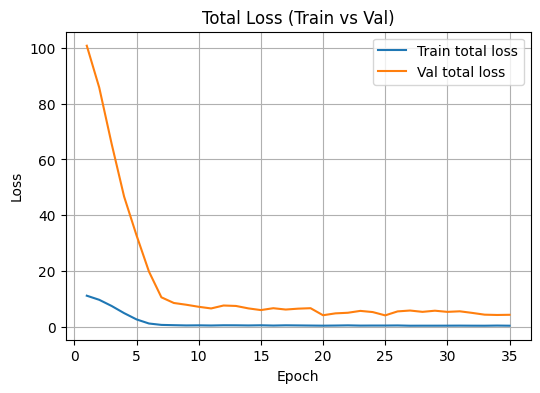

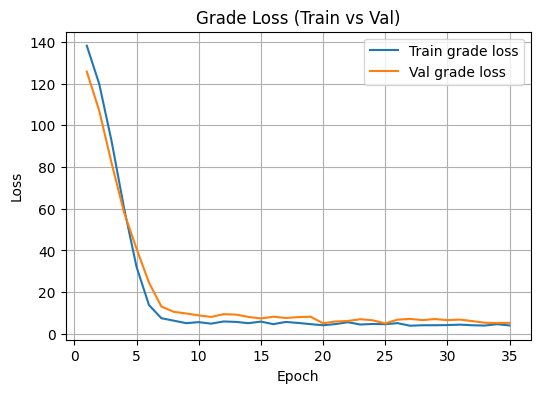

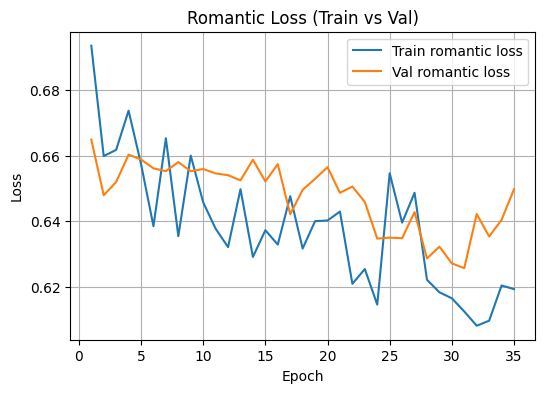

In [17]:
import matplotlib.pyplot as plt


epochs = range(1, num_epochs + 1)

plt.figure(figsize=(6, 4))
plt.plot(epochs, train_total_losses, label="Train total loss")
plt.plot(epochs, val_total_losses, label="Val total loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Total Loss (Train vs Val)")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(6, 4))
plt.plot(epochs, train_grade_losses, label="Train grade loss")
plt.plot(epochs, val_grade_losses, label="Val grade loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Grade Loss (Train vs Val)")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(6, 4))
plt.plot(epochs, train_rom_losses, label="Train romantic loss")
plt.plot(epochs, val_rom_losses, label="Val romantic loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Romantic Loss (Train vs Val)")
plt.legend()
plt.grid(True)
plt.show()




In [18]:
import torch
import numpy as np
from sklearn.metrics import f1_score, accuracy_score, classification_report

model.eval()

y_true_cls, y_pred_cls = [], []
y_true_reg, y_pred_reg = [], []

with torch.no_grad():
    for X_batch, y_grade_batch, y_romantic_batch in test_loader:
        grade_pred, romantic_pred = model(X_batch)

        # Store regression values
        y_true_reg.extend(y_grade_batch.cpu().numpy())
        y_pred_reg.extend(grade_pred.squeeze().cpu().numpy())

        # Store classification values
        preds = torch.argmax(romantic_pred, dim=1)
        y_true_cls.extend(y_romantic_batch.cpu().numpy())
        y_pred_cls.extend(preds.cpu().numpy())


y_true_reg_inv = np.array(y_true_reg)
y_pred_reg_inv = np.array(y_pred_reg)

# --- Compute regression metrics ---
mae = np.mean(np.abs(y_true_reg_inv - y_pred_reg_inv))
rmse = np.sqrt(np.mean((y_true_reg_inv - y_pred_reg_inv) ** 2))

# --- Compute classification metrics ---
accuracy = accuracy_score(y_true_cls, y_pred_cls)
f1 = f1_score(y_true_cls, y_pred_cls, pos_label=1)

# --- Print final evaluation results ---
print("=== Final Test Results ===")
print(f"MAE (Grade Prediction): {mae:.3f}")
print(f"RMSE (Grade Prediction): {rmse:.3f}")
print(f"Accuracy (Romantic Prediction): {accuracy:.3f}")
print(f"F1-Score (Romantic, class=1): {f1:.3f}")
print("\nDetailed Classification Report:")
print(classification_report(y_true_cls, y_pred_cls, target_names=["Not romantic", "Romantic"]))


=== Final Test Results ===
MAE (Grade Prediction): 3.266
RMSE (Grade Prediction): 4.142
Accuracy (Romantic Prediction): 0.663
F1-Score (Romantic, class=1): 0.353

Detailed Classification Report:
              precision    recall  f1-score   support

Not romantic       0.67      0.90      0.77        62
    Romantic       0.60      0.25      0.35        36

    accuracy                           0.66        98
   macro avg       0.64      0.58      0.56        98
weighted avg       0.65      0.66      0.62        98



I tried 5 fold cross validation to monitor how accuracy averaged across folds and to make sure that model was not overfitting. model does not overfit, but it showed that romatic head is consistenly much weaker so i decided to tune some params. this is output of cross validation                              

*   Fold 1: Val MSE=0.156, Romantic Acc=0.615
*   Fold 2: Val MSE=0.229, Romantic Acc=0.638
*   Fold 3: Val MSE=0.264, Romantic Acc=0.654
*   Fold 4: Val MSE=0.163, Romantic Acc=0.608
*   Fold 5: Val MSE=0.213, Romantic Acc=0.643

Average across folds = > Grade MSE=0.205, Romantic Acc=0.632                                                                                       

I tried following things to improve performance of romantic head                 

*   tuning weights for loss functions but then grade error increased and romantic accuracy slightly increased, overall loss increased
*   added layer to romantic head but it obviously didnt work since issue is not the simplicity of the model
*  i experimented with number of epochs. large epoch sizes : 50-100 caused overfititng, both errors were increasing in evaluation loop and decreasing in training. most optimal was 35
*   i experimented also experimented with dropout and learning rate. learning rate was giving best result when it was 0.0005, and dropout 0.3 : golden balance between overfitting and underfitting. i tried to add dropout to romantic head to make sure it generalized better but made it worse -> likely because the head is already relatively small and the dataset is not large, model underfitted.





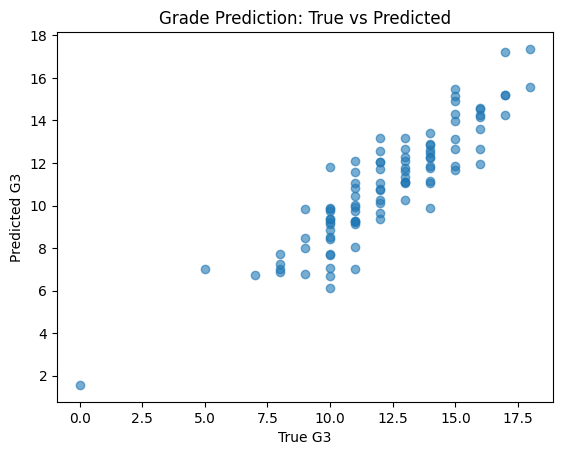

In [19]:
import matplotlib.pyplot as plt

#  plotting grade prediction score

plt.scatter(y_true_reg, y_pred_reg, alpha=0.6)
plt.xlabel("True G3")
plt.ylabel("Predicted G3")
plt.title("Grade Prediction: True vs Predicted")
plt.show()



In [20]:
MODEL_PATH = "multitask_student_model.pt"
torch.save(model.state_dict(), MODEL_PATH)
print(f"Model weights saved as {MODEL_PATH}")


Model weights saved as multitask_student_model.pt
